In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline

In [2]:
# Use the matplotlib plotting styles
CURR_PATH = pathlib.Path().parent
MPLSTYLE = CURR_PATH.joinpath("plotstyle.mplstyle")
plt.style.use(MPLSTYLE)

In [3]:
def read_txt_pd(otype: str = "inclusive", charge: str = "nu") -> pd.DataFrame:
    
    path = f"clipped_nan_binned_sysevents_FASERv2_{otype}_{charge}.txt"
    fpath = CURR_PATH.joinpath(f"NNPDF_commondata/stat_syst_uncertainties/{path}")
    
    colnames = [
        "x_lower", 
        "x_upper", 
        "x_avg", 
        "Q2_lower", 
        "Q2_upper", 
        "Q2_avg", 
        "E_nu_lower", 
        "E_nu_upper", 
        "E_nu_avg", 
        "d^sigma/dxdQ2", 
        "N_events", 
        "N_events_errs", 
        "N_sys_errs", 
        "Percent_error_theta", 
        "Percent_error_Elepton", 
        "Percent_error_Ehadron", 
        "MC_Samples",
    ]
    
    return pd.read_csv(fpath, skiprows=2, delim_whitespace=True, names=colnames)

In [51]:
def map_q2values(q2_min, q2_max):
    q2min, q2max = int(q2_min), int(q2_max)
    spacing = np.linspace(6, 350, num=4, endpoint=True).astype(int)
    
    def value_mmapping(q2_value):     
        if q2_value <= spacing[1]:
            return r"$[" + f"{spacing[0]},~{spacing[1]}" + "]~\mathrm{GeV}^2$"
        elif (spacing[1] <= q2_value) and (q2_value <= spacing[2]):
            return r"$[" + f"{spacing[1]},~{spacing[2]}" + "]~\mathrm{GeV}^2$"
        else:
            return r"$[" + f"{spacing[2]},~{spacing[3]}" + "]~\mathrm{GeV}^2$"

    return value_mmapping

In [52]:
def combine_tables() -> pd.DataFrame:
    otypes = ["inclusive", "charm"]
    charges = ["nu", "nub"]
    map_charges = {"nu": r"$\nu$", "nub": r"$\bar{\nu}$"}
    map_otypes = {
        "inclusive": r"$\nu / \bar{\nu} + N \to \ell^{\pm} + X$",
        "charm": r"$\nu / \bar{\nu} + N \to \ell^{\pm} + c / \bar{c} + X$",
    }
    
    combined_tables= []
    for otype, charge in product(otypes, charges):
        df = read_txt_pd(otype, charge)
        df["otype"] = [map_otypes[otype]] * len(df)
        df["charge"] = [map_charges[charge]] * len(df)
        
        combined_tables.append(df)
    
    df_combined = pd.concat(combined_tables, ignore_index=True)
    # Map the values of Q2 to some string ranges
    q2min, q2max = df_combined["Q2_avg"].min(), df_combined["Q2_avg"].max(),
    df_combined["Q2_avg"] = df_combined["Q2_avg"].map(map_q2values(q2min, q2max))

    return df_combined

In [53]:
predictions = combine_tables()

In [54]:
# predictions["Q2_avg"].unique().tolist()

In [55]:
rename_columns = {
    "Q2_avg": r"$Q^2~\rm{Ranges}$",
    "otype": r"$\rm{Processes}$",
    "charge": r"$\rm{Projectile~Charges}$",
}

def plot_percentage_error(data: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(5, 3))
    
    data = data.rename(columns=rename_columns)
    # import ipdb; ipdb.set_trace()
    
    sns.scatterplot(
        data=data,
        x="x_avg",
        y="Percent_error_Elepton",
        hue=r"$\rm{Processes}$",
        style=r"$\rm{Projectile~Charges}$",
        size=r"$Q^2~\rm{Ranges}$",
    )
    
    ax.set_xscale("log")
    ax.set_xlabel(r"$x_{\rm mean}$")
    ax.set_ylabel(r"$\rm{Percentage~Error~}(E_{\ell})$")
    ax.set_ylim(top=0.2)
    
    plt.legend(
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        loc="lower left",
        mode="expand",
        borderaxespad=0.0,
        ncol=2,
        fontsize=10,
        fancybox=True,
        edgecolor="inherit",
    )
    
    fig.savefig("plots/percentage_error_El.pdf", bbox_inches="tight", dpi=350)
    plt.show()

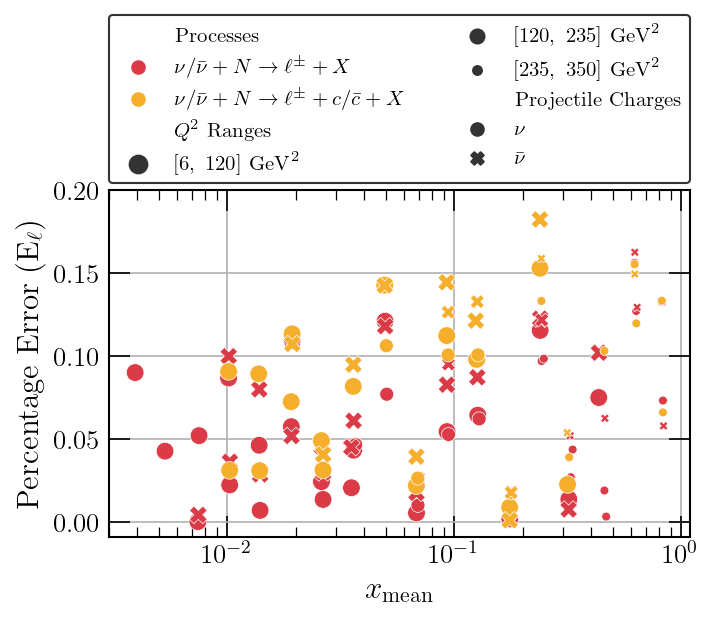

In [56]:
plot_percentage_error(predictions)